In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [2]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = 25*sin.(features*[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0];

In [3]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     …  8.02953    8.61508   1.0   41.2264
 4.43494   8.65398   4.38668       4.26558    5.79587   0.0   10.2415
 7.45673   7.98071   9.35901       7.38559    9.99516   0.0   27.5137
 5.12083   8.25448   8.79223       0.835565   8.06585   0.0   24.796
 2.53849   5.30423   5.84012       0.570453   9.6668    0.0   22.6625
 3.34152   2.66141   9.8669     …  0.92876    9.49805   1.0   20.3578
 4.27328   8.75436   0.0258112     5.12688    2.24987   1.0  -13.6265
 8.67547   7.27313   0.151025      0.0873517  0.765286  0.0   25.0373
 0.991336  1.20752   5.87184       8.38971    9.81301   0.0   20.8175
 1.25287   6.88003   3.64868       4.16181    3.00126   0.0   26.2578
 6.92209   0.298644  4.84843    …  8.07655    1.49476   0.0   36.4211
 1.36551   1.07227   0.570038      2.53062    7.60498   1.0   45.4647
 0.320967  6.45858   4.85281       9.74512    1.98433   0.0   32.6943
 ⋮                              ⋱                       ⋮    
 1.

In [4]:
#header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
#writedlm("sinus_causal_4.csv", [header ; df], ",")

In [5]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = 25*sin.(Xtest_1[:, 1]);

In [6]:
function get_all_nodes_in_tree!(
    tree ,
    depth = 3,
    result  = []
    )
    if hasproperty(tree, :featid) && depth > 0
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, depth-1, result)
        get_all_nodes_in_tree!(tree.right, depth-1, result)
    end
    return result
end

function get_freq(forest, depth=3) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree, depth))
    end
    return proportionmap(res)
end

get_freq (generic function with 2 methods)

# Critère nouveau

### Subsampling

In [7]:
errors_11 = zeros(100)

cf = build_forest(false, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = 25*sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_11))
println(var(errors_11))

0.11224152682255097
8.82250828695862e-6


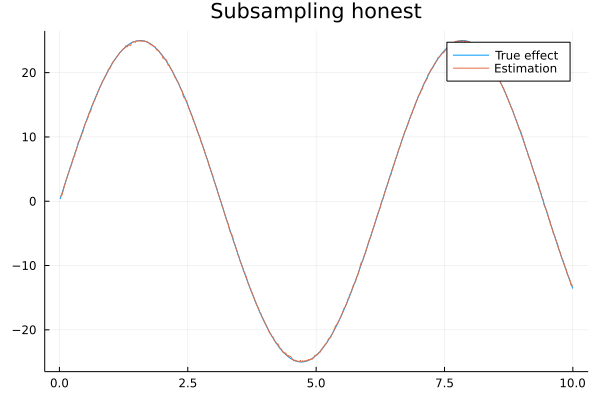

In [8]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Subsampling honest", fmt = :png)

In [9]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [10]:
get_freq(cf, 5)

Dict{Any, Float64} with 8 entries:
  5  => 0.000518639
  6  => 0.000194489
  7  => 6.48298e-5
  2  => 0.000194489
  10 => 0.00012966
  9  => 0.000194489
  8  => 0.000324149
  1  => 0.998379

In [11]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.00943385
  4  => 0.00942212
  6  => 0.0100909
  7  => 0.00950425
  2  => 0.0101027
  10 => 0.00939865
  9  => 0.00896451
  8  => 0.0107363
  3  => 0.00891757
  1  => 0.913429

### Bootstrap

In [12]:
errors_12 = zeros(100)

cf = build_forest(true, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = 25*sin.(Xtest[:, 1])
    errors_12[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_12))
println(var(errors_12))

0.2701071273170059
4.698321464755467e-5


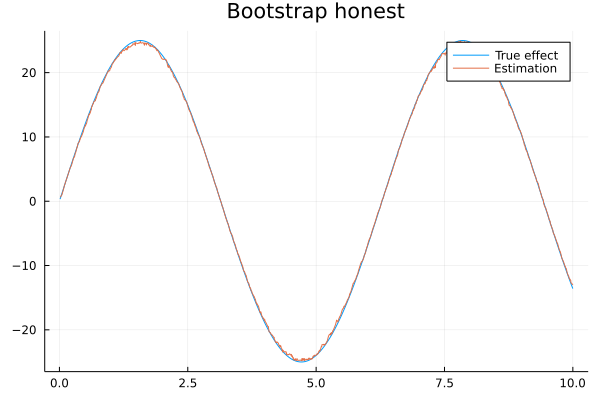

In [13]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Bootstrap honest", fmt = :png)

In [14]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [15]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.000323792
  4  => 0.000388551
  6  => 0.000194275
  7  => 0.000582826
  2  => 0.000323792
  10 => 0.000129517
  9  => 0.000582826
  8  => 0.000388551
  3  => 0.000712343
  1  => 0.996374

In [16]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0240416
  4  => 0.0241816
  6  => 0.0256276
  7  => 0.025637
  2  => 0.0254224
  10 => 0.02476
  9  => 0.0241629
  8  => 0.0260101
  3  => 0.025525
  1  => 0.774632